In [1]:
import re
import os
import warnings
import copy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import category_encoders as ce
import ipynb_path

from lightgbm import LGBMModel, LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## config

In [2]:
class Config:
    n_classes = 8
    n_folds = 5
    k = 100
    exp_name = re.findall(r"exp.+?(?=\.)", ipynb_path.get())[0]
    input_path = "../input"
    sub_path = "../submission"


warnings.filterwarnings("ignore")
sns.set(font="Yu Gothic")

## load data & データ整備

In [3]:
Train = pd.read_csv(os.path.join(Config.input_path, "train_data.csv"))
Test = pd.read_csv(os.path.join(Config.input_path,
                                "test_data_improvement.csv"))
Game_info = pd.read_csv(os.path.join(Config.input_path, "game_info.csv"))

train, test, game_info = Train.copy(), Test.copy(), Game_info.copy()

In [4]:
# train, test と game_infoの結合
train = train[~train.drop('id', axis=1).duplicated()]
train = pd.merge(train,
                 game_info.drop(["bgTop", "bgBottom"], axis=1),
                 on="gameID",
                 how="left")
f = train["inning"].str.contains("表")
train.loc[f, "batter"] = train.loc[f, "batter"] + \
    "@" + train.loc[f, "topTeam"].astype(str)
train.loc[~f, "batter"] = train.loc[~f, "batter"] + \
    "@" + train.loc[~f, "bottomTeam"].astype(str)
train.loc[f, "pitcher"] = train.loc[f, "pitcher"] + \
    "@" + train.loc[f, "bottomTeam"].astype(str)
train.loc[~f, "pitcher"] = train.loc[~f, "pitcher"] + \
    "@" + train.loc[~f, "topTeam"].astype(str)

test = test[~test.drop('id', axis=1).duplicated()]
test = pd.merge(test,
                game_info.drop(["bgTop", "bgBottom"], axis=1),
                on="gameID",
                how="left")
f = test["inning"].str.contains("表")
test.loc[f, "batter"] = test.loc[f, "batter"] + \
    "@" + test.loc[f, "topTeam"].astype(str)
test.loc[~f, "batter"] = test.loc[~f, "batter"] + \
    "@" + test.loc[~f, "bottomTeam"].astype(str)
test.loc[f, "pitcher"] = test.loc[f, "pitcher"] + \
    "@" + test.loc[f, "bottomTeam"].astype(str)
test.loc[~f, "pitcher"] = test.loc[~f, "pitcher"] + \
    "@" + test.loc[~f, "topTeam"].astype(str)

In [5]:
class GroupKFold(object):
    """
    GroupKFold with random shuffle with a sklearn-like structure
    refer to katsu
    """
    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X=None, y=None, group=None):
        kf = KFold(n_splits=self.n_splits,
                   shuffle=self.shuffle,
                   random_state=self.random_state)
        unique_ids = group.unique()
        for tr_group_idx, va_group_idx in kf.split(unique_ids):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[
                va_group_idx]
            train_idx = np.where(group.isin(tr_group))[0]
            val_idx = np.where(group.isin(va_group))[0]
            yield train_idx, val_idx

In [6]:
# cv strategy
def gkf(X,
        y,
        n_splits=Config.n_folds,
        random_state=46,
        shuffle=True,
        group=None):
    cv_strategy = GroupKFold(n_splits=n_splits,
                             random_state=random_state,
                             shuffle=shuffle)
    cv = cv_strategy.split(X, y, group)
    return list(cv)

## preprocess

In [7]:
def get_pit_features(input_df, test_df):
    input_df["speed"] = input_df["speed"].replace(
        "-", "0km/h").apply(lambda x: int(x[:-4]))
    _df = pd.DataFrame(input_df["pitcher"].unique(), columns=["pitcher"])
    _df = _df.merge(input_df.groupby("pitcher")["pitchType"].agg(
        pd.Series.nunique).rename("NumPitchType"),
                    left_on="pitcher",
                    right_index=True)
    _df = _df.merge(
        input_df.groupby("pitcher")["speed"].agg("max").rename("maxSpeed"),
        left_on="pitcher",
        right_index=True)
    _df = _df.merge(input_df.groupby("pitcher")["speed"].agg("median").rename(
        "medianSpeed"),
                    left_on="pitcher",
                    right_index=True)
    _df = _df.merge(
        input_df.groupby("pitcher")["speed"].agg("min").rename("minSpeed"),
        left_on="pitcher",
        right_index=True)
    _df = _df.merge(
        input_df.groupby("pitcher")["speed"].agg("std").rename("stdSpeed"),
        left_on="pitcher",
        right_index=True)
    _df = _df.merge(input_df.groupby("pitcher").agg("size").rename("size"),
                    left_on="pitcher",
                    right_index=True)
    tmp = _df.merge(input_df[input_df["y"] >= 4].groupby("pitcher").agg(
        "size").rename("hitCount"),
                    left_on="pitcher",
                    right_index=True)  # hit以上の回数(hit or homerun)
    tmp = tmp[["pitcher", "hitCount"]]
    pit_dict = dict(zip(tmp["pitcher"], tmp["hitCount"]))
    _df["hitCount"] = _df["pitcher"].map(pit_dict).fillna(0).apply(
        lambda x: int(x))
    _df["hitRatio"] = _df["hitCount"] / _df["size"]

    output_df = _df
    output_df = pd.merge(input_df, _df, on="pitcher")
    output_test = pd.merge(test_df, _df, on="pitcher")
    return output_df, output_test


def get_bat_features(input_df, test_df):
    _df = pd.DataFrame(input_df["batter"].unique(), columns=["batter"])
    _df = _df.merge(input_df.groupby("batter").agg("size").rename("bat_size"),
                    left_on="batter",
                    right_index=True)
    tmp = _df.merge(input_df[input_df["y"] >= 4].groupby("batter").agg(
        "size").rename("bat_hitCount"),
                    left_on="batter",
                    right_index=True)  # hit以上の回数(hit or homerun)
    tmp = tmp[["batter", "bat_hitCount"]]
    bat_dict = dict(zip(tmp["batter"], tmp["bat_hitCount"]))
    _df["bat_hitCount"] = _df["batter"].map(bat_dict).fillna(0).apply(
        lambda x: int(x))
    _df["bat_hitRatio"] = _df["bat_hitCount"] / _df["bat_size"]
    output_df = _df
    output_df = pd.merge(input_df, _df, on="batter")
    output_test = pd.merge(test_df, _df, on="batter")
    return output_df, output_df


def get_gameinfo_features(input_df):
    _df = input_df.copy()
    _df[["b1", "b2", "b3"]] = _df[["b1", "b2", "b3"]].astype(int).astype(str)
    output_df = _df.copy()
    output_df["b1-b2-b3"] = output_df["b1"] + "-" + \
        output_df["b2"] + "-" + output_df["b3"]
    output_df["pitcherHand-batterHand"] = output_df["pitcherHand"].fillna(
        "NaN") + "-" + output_df["batterHand"].fillna("NaN")

    output_df = pd.DataFrame(output_df[["b1-b2-b3", "pitcherHand-batterHand"]])

    return output_df


def get_homeaway_features(input_df):
    df = input_df.copy()
    home_dic = {
        "日本ハム": ["札幌ドーム"],
        "楽天": ["楽天生命パーク"],
        "西武": ["メットライフ"],
        "ロッテ": ["ZOZOマリン"],
        "巨人": ["東京ドーム"],
        "ヤクルト": ["神宮"],
        "DeNA": ["横浜"],
        "中日": ["ナゴヤドーム"],
        "オリックス": ["京セラD大阪", "ほっと神戸"],
        "阪神": ["甲子園"],
        "広島": ["マツダスタジアム"],
        "ソフトバンク": ["PayPayドーム"]
    }
    idxs = df["pitcher"].apply(lambda x: x[x.find("@") + 1:])
    home_li = []
    for idx, place in zip(idxs, df["place"]):
        if place in home_dic[idx]:
            home_li.append(True)
        else:
            home_li.append(False)

    df["pit_home"] = pd.Series(home_li)
    df["bat_home"] = ~df["pit_home"]
    output_df = df[["pit_home", "bat_home"]]

    return output_df


def get_numerical_raw_features(input_df):
    cols = [
        "totalPitchingCount", "B", "S", "O", "b1", "b2", "b3", "pit_home",
        "bat_home"
    ]
    output_df = input_df[cols].copy()

    return output_df


def get_oe_features(input_df):
    cols = [
        'pitcher', 'pitcherHand', 'batter', 'batterHand', 'inning', 'b1-b2-b3',
        "pitcherHand-batterHand", "bottomTeam", "topTeam", "place", "startTime"
    ]

    encoder = ce.OrdinalEncoder()
    output_df = encoder.fit_transform(input_df[cols])

    return output_df.add_prefix("OE_")


def get_ce_features(input_df):
    cols = [
        'pitcher', 'pitcherHand', 'batter', 'batterHand', 'inning', 'b1-b2-b3',
        "pitcherHand-batterHand", "bottomTeam", "topTeam", "place", "startTime"
    ]
    encoder = ce.CountEncoder()
    output_df = encoder.fit_transform(input_df[cols])
    return output_df.add_prefix("CE_")


def get_tews_features(input_df, test_df):
    '''
    target encodingとsmoothingの実装
    '''
    cols = [
        'pitcher', 'pitcherHand', 'batter', 'batterHand', 'inning', 'b1-b2-b3',
        "pitcherHand-batterHand", "bottomTeam", "topTeam", "place", "startTime"
    ]
    for c in cols:
        tmp_df = pd.DataFrame({c: input_df[c], 'y': input_df["y"]})
        dum = pd.get_dummies(
            tmp_df["y"]).rename(columns=lambda x: "TE" + "_" + c + str(x + 1))
        tmp_df = pd.concat([tmp_df, dum], axis=1).drop("y", axis=1)
        df_li = []
        for i in range(1, 9):
            col = "TE" + "_" + c + str(i)
            target_mean = tmp_df.groupby(c)[col].mean()
            ni_dict = dict(tmp_df[c].value_counts())
            for key, value in zip(ni_dict.keys(), ni_dict.values()):
                lambda_ni = 1 / (1 + np.exp(-value / Config.k))
                n_iy = tmp_df[tmp_df[c] == key][col].sum()
                n_y = tmp_df[col].sum()
                n_tr = len(tmp_df)
                target_mean[key] = (lambda_ni*n_iy)/value + \
                    (1 - lambda_ni)*n_y/n_tr
            df_li.append(target_mean)
        target_df = pd.concat(df_li, axis=1)
        test_df = pd.merge(test_df, target_df, on=c, how="left")

        cv = gkf(X=input_df,
                 y=test_df,
                 n_splits=Config.n_folds,
                 random_state=46,
                 shuffle=True,
                 group=train["gameID"])

        train_li = []
        for idx_1, idx_2 in cv:
            tmp_df2 = tmp_df.iloc[idx_1].reset_index()
            df_li = []
            col_list = []
            for i in range(1, 9):
                col = "TE" + "_" + c + str(i)
                target_mean = tmp_df2.groupby(c)[col].mean()
                ni_dict = dict(tmp_df2[c].value_counts())
                for key, value in zip(ni_dict.keys(), ni_dict.values()):
                    lambda_ni = 1 / (1 + np.exp(-value / Config.k))
                    n_iy = tmp_df2[tmp_df2[c] == key][col].sum()
                    n_y = tmp_df2[col].sum()
                    n_tr = len(tmp_df2)
                    target_mean[key] = (lambda_ni*n_iy) / \
                        value + (1 - lambda_ni)*n_y/n_tr
                df_li.append(target_mean)
                col_list.append(col)
            target_df2 = pd.concat(df_li, axis=1)
            tmp_df3 = tmp_df.iloc[idx_2].reset_index()
            append_df = pd.merge(tmp_df3, target_df2, on=c).iloc[:, 10:]
            append_df["id__"] = tmp_df3["index"]
            for i in range(len(append_df.columns)):
                append_df.rename(
                    columns={append_df.columns[i]: append_df.columns[i][:-2]},
                    inplace=True)
            train_li.append(append_df)

        merge_df = pd.concat(train_li, axis=0)
        merge_df.sort_values("id", inplace=True)
        input_df = pd.merge(input_df, merge_df, on="id", how="left")
    output_df = input_df

    return output_df, test_df


def preprocess(train, test):
    whole_df = pd.concat([train, test]).reset_index(drop=True)
    whole_df = pd.concat([whole_df, get_gameinfo_features(whole_df)], axis=1)
    whole_df = pd.concat([whole_df, get_homeaway_features(whole_df)], axis=1)

    funcs = [
        get_numerical_raw_features,
        get_oe_features,
        get_ce_features,
    ]

    output_lst = []
    for func in funcs:
        _df = func(whole_df)
        output_lst.append(_df)

    output_df = pd.concat(output_lst, axis=1)

    pre_train_x = output_df.iloc[:len(train)]
    pre_test_x = output_df.iloc[len(train):].reset_index(drop=True)

    funcs2 = [get_pit_features, get_bat_features]
    output_lst2 = []
    for func in funcs2:
        pre2_train_x, pre2_test_x = func(train, test)
        output_lst2.append([pre2_train_x, pre2_test_x])

    _cols_to_use1 = output_lst2[0][0].columns.difference(
        output_lst2[1][0].columns)
    pre2_train_x = pd.concat(
        [output_lst2[0][0][list(_cols_to_use1)], output_lst2[1][0]], axis=1)
    _cols_to_use2 = output_lst2[0][1].columns.difference(
        output_lst2[1][1].columns)
    pre2_test_x = pd.concat(
        [output_lst2[0][1][list(_cols_to_use2)], output_lst2[1][1]], axis=1)

    _use1 = pre2_train_x.columns.difference(train.columns)
    _use2 = pre2_test_x.columns.difference(train.columns)
    train_x = pd.concat([pre_train_x, pre2_train_x[list(_use1)]], axis=1)
    test_x = pd.concat([pre_test_x, pre2_test_x[list(_use2)]], axis=1)

    pre_tr_3, pre_te_3 = get_tews_features(
        pd.concat([train, get_gameinfo_features(train)], axis=1),
        pd.concat([test, get_gameinfo_features(test)], axis=1))
    _use_tr = pre_tr_3.columns.difference(train.columns)
    _use_te = pre_te_3.columns.difference(test.columns)

    train_x = pd.concat([train_x, pre_tr_3[list(_use_tr)]],
                        axis=1).drop(["b1-b2-b3", "pitcherHand-batterHand"],
                                     axis=1)
    test_x = pd.concat([test_x, pre_te_3[list(_use_te)]],
                       axis=1).drop(["b1-b2-b3", "pitcherHand-batterHand"],
                                    axis=1)

    return train_x, test_x

In [8]:
# feature engineering
train_x, test_x = preprocess(train, test)
train_y = train["y"]

In [9]:
def get_Poly_features(input_df):
    cols = list(input_df.columns[input_df.dtypes != "object"])
    input_df = input_df[cols]
    pf = PolynomialFeatures(degree=2,
                            interaction_only=False,
                            include_bias=False)
    output_df = pd.DataFrame(pf.fit_transform(input_df))

    return output_df


#train_x, test_x = get_Poly_features(train_x.fillna(train_x.mean())), get_Poly_features(test_x.fillna(test_x.mean()))

## train

In [10]:
def macro_f1(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)  # label
    score = f1_score(y_true, y_pred, average="macro")
    return score

In [11]:
def train_lgb(X, y, lgb_params, cv, metrics):

    model = LGBMClassifier(**lgb_params)

    oof = np.zeros((len(y), Config.n_classes))
    models = []
    for i_fold, (tr_idx, va_idx) in enumerate(cv):

        tr_x, va_x = X.iloc[tr_idx].reset_index(
            drop=True), X.iloc[va_idx].reset_index(drop=True)
        tr_y, va_y = y.iloc[tr_idx].reset_index(
            drop=True), y.iloc[va_idx].reset_index(drop=True)

        model.fit(tr_x,
                  tr_y,
                  eval_set=[[va_x, va_y]],
                  early_stopping_rounds=500,
                  verbose=500)
        models.append(copy.copy(model))
        pred = model.predict_proba(va_x)
        score = metrics(va_y, pred)
        print(f"fold:{i_fold} >>> {score:.4f}")
        oof[va_idx] = pred

    score = metrics(y, oof)
    print(f"score: {score:4f}")

    return oof, models

In [12]:
cv = gkf(X=train_x,
         y=train_y,
         n_splits=Config.n_folds,
         random_state=46,
         shuffle=True,
         group=train["gameID"])

lgb_params = {
    'objective': 'multiclass',
    'num_class': 8,
    'importance_type': 'gain',
    'n_jobs': -1,
    'class_weight': 'balanced',
    'n_estimators': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'num_leaves': 32,
    'colsample_bytree': 0.5614,
    'subsample': 0.8975,
    'subsample_freq': 73,
    'min_child_samples': 14,
    'min_child_weight': 34.08,
    'max_bin': 138,
    'reg_alpha': 0.05796,
    'reg_lambda': 0.0002102
}

oof, models = train_lgb(X=train_x,
                        y=train_y,
                        lgb_params=lgb_params,
                        cv=cv,
                        metrics=macro_f1)

Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.67308
[1000]	valid_0's multi_logloss: 1.61562
[1500]	valid_0's multi_logloss: 1.60503
[2000]	valid_0's multi_logloss: 1.60449
Early stopping, best iteration is:
[1601]	valid_0's multi_logloss: 1.60306
fold:0 >>> 0.1493
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.68301
[1000]	valid_0's multi_logloss: 1.62375
[1500]	valid_0's multi_logloss: 1.61134
[2000]	valid_0's multi_logloss: 1.6121
Early stopping, best iteration is:
[1794]	valid_0's multi_logloss: 1.61028
fold:1 >>> 0.1605
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.65672
[1000]	valid_0's multi_logloss: 1.60731
[1500]	valid_0's multi_logloss: 1.5932
[2000]	valid_0's multi_logloss: 1.59184
Early stopping, best iteration is:
[1808]	valid_0's multi_logloss: 1.58982
fold:2 >>> 0.1541
Training until validation scores don't improve for 500 round

## predict

In [13]:
def predict_cv(X, models):

    preds = []
    for i_model, model in enumerate(models):
        pred = model.predict_proba(X)
        preds.append(pred)
        print(f"predict >>> model:{i_model}")

    preds = np.mean(preds, axis=0)
    return preds

In [14]:
preds = predict_cv(test_x, models)

predict >>> model:0
predict >>> model:1
predict >>> model:2
predict >>> model:3
predict >>> model:4


In [15]:
def visualize_confusion_matrix(y_true, pred_label, height=.6, labels=None):
    conf = confusion_matrix(y_true=y_true, y_pred=pred_label, normalize='true')
    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 3, size * 2))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')
    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)
    return fig

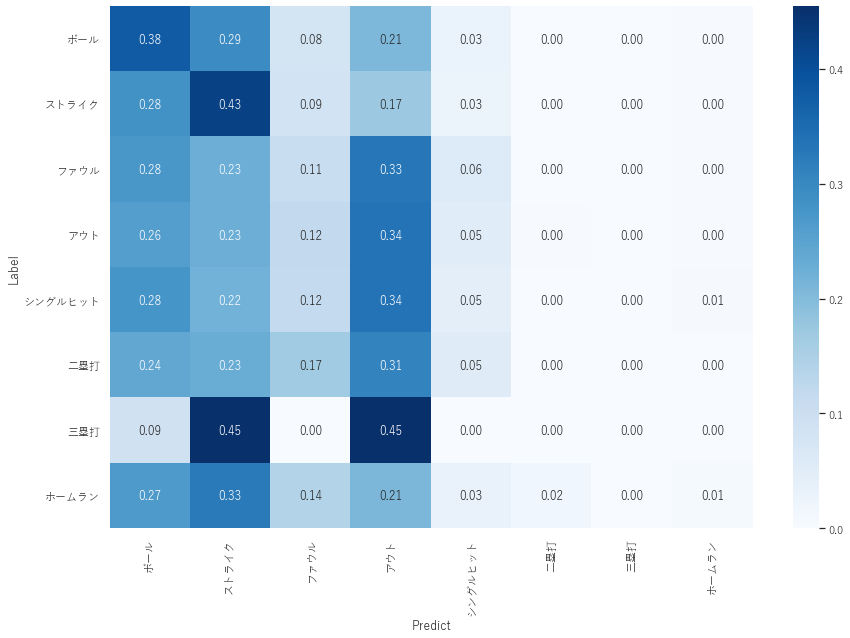

In [16]:
oof_label = np.argmax(oof, axis=1)
labels = ["ボール", "ストライク", "ファウル", "アウト", "シングルヒット", "二塁打", "三塁打", "ホームラン"]
fig = visualize_confusion_matrix(y_true=train_y,
                                 pred_label=oof_label,
                                 labels=labels)

## feature importance

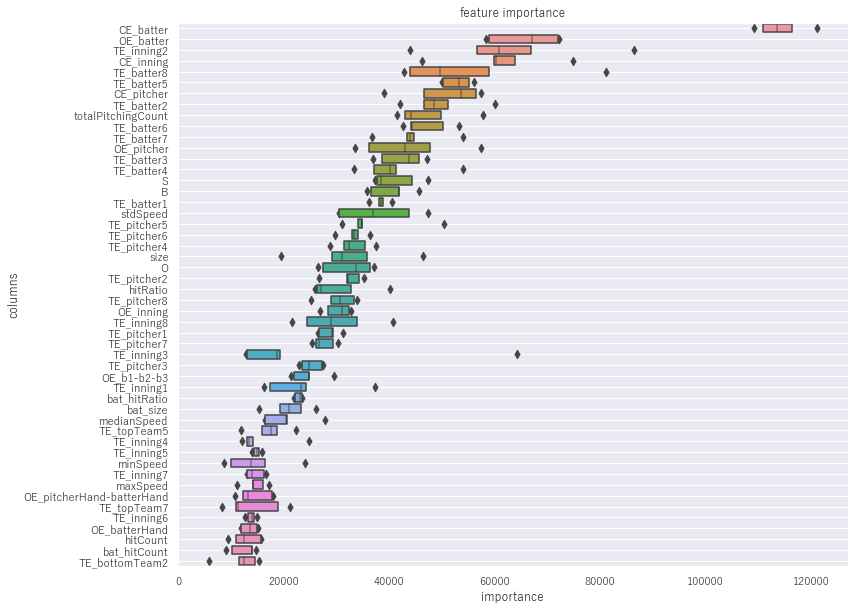

In [17]:
def lgb_importance(X, y, lgb_params, cv, trained_models=None):

    model = LGBMClassifier(**lgb_params)
    importance_df = []
    for i_fold, (tr_idx, va_idx) in enumerate(cv):

        tr_x, va_x = X.iloc[tr_idx].reset_index(
            drop=True), X.iloc[va_idx].reset_index(drop=True)
        tr_y, va_y = y.iloc[tr_idx].reset_index(
            drop=True), y.iloc[va_idx].reset_index(drop=True)

        if trained_models is None:
            model.fit(tr_x,
                      tr_y,
                      eval_set=[[va_x, va_y]],
                      early_stopping_rounds=100,
                      verbose=100)
        else:
            model = trained_models[i_fold]

        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["columns"] = tr_x.columns
        _df["fold"] = i_fold + 1
        importance_df.append(_df)
    importance_df = pd.concat(importance_df).reset_index(drop=True)
    order = importance_df.groupby("columns").sum()[["importance"]].sort_values(
        "importance", ascending=False).index

    fix, ax = plt.subplots(figsize=(12, max(4, len(order[:50]) * .2)))
    sns.boxenplot(data=importance_df,
                  y="columns",
                  x="importance",
                  order=order[:50],
                  ax=ax)
    ax.grid()
    ax.set_title('feature importance')

    return order


feat_names = lgb_importance(train_x, train_y, lgb_params, cv, models)

## make submission

In [18]:
labels = np.argmax(preds, axis=1)
submit_df = pd.DataFrame({'y': labels})
submit_df.index.name = 'id'
file_name = os.path.join(Config.sub_path, f"{Config.exp_name}.csv")
submit_df.to_csv(file_name)

In [19]:
submit_df

,y
id,
0,1
1,1
2,3
3,1
4,1
...,...
33803,0
33804,0
33805,0


In [20]:
submit_df.value_counts()

y
1    12486
0    10760
3     5153
2     3993
4     1379
7       30
5        7
dtype: int64

Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.67308
[1000]	valid_0's multi_logloss: 1.61562
[1500]	valid_0's multi_logloss: 1.60503
[2000]	valid_0's multi_logloss: 1.60449
Early stopping, best iteration is:
[1601]	valid_0's multi_logloss: 1.60306
fold:0 >>> 0.1493
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.68301
[1000]	valid_0's multi_logloss: 1.62375
[1500]	valid_0's multi_logloss: 1.61134
[2000]	valid_0's multi_logloss: 1.6121
Early stopping, best iteration is:
[1794]	valid_0's multi_logloss: 1.61028
fold:1 >>> 0.1605
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.65672
[1000]	valid_0's multi_logloss: 1.60731
[1500]	valid_0's multi_logloss: 1.5932
[2000]	valid_0's multi_logloss: 1.59184
Early stopping, best iteration is:
[1808]	valid_0's multi_logloss: 1.58982
fold:2 >>> 0.1541
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.67453
[1000]	valid_0's multi_logloss: 1.63704
[1500]	valid_0's multi_logloss: 1.62288
[2000]	valid_0's multi_logloss: 1.62679
Early stopping, best iteration is:
[1560]	valid_0's multi_logloss: 1.62171
fold:3 >>> 0.1565
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.65033
[1000]	valid_0's multi_logloss: 1.60142
[1500]	valid_0's multi_logloss: 1.58353
[2000]	valid_0's multi_logloss: 1.58274
Early stopping, best iteration is:
[1829]	valid_0's multi_logloss: 1.58007
fold:4 >>> 0.1519
## CV score: 0.154694